### Importing packages

In [1]:
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import logging
import os
import random
import sys
from dataclasses import dataclass, field
from typing import Optional

import datasets
import numpy as np
from datasets import load_dataset, load_metric

# Torch modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Lightning modules
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torchmetrics.classification import MulticlassAUROC
from torchmetrics import F1Score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import transformers
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version
from transformers.utils.versions import require_version

tqdm.pandas()

C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Reading in dataset

In [3]:
df_ACL_2020 = pd.read_csv("./Data/ACL_2022.csv")
df_EMNLP_2020 = pd.read_csv("./Data/EMNLP_2020.csv")

In order to get the full and abstracted text, we use the 74k extracted dataset from earlier

In [4]:
df_base = pd.read_parquet("./Data/acl-publication-info.74k.parquet")

In [5]:
df_base = df_base[['title', 'author', "abstract", "full_text"]]

In [6]:
df_base['title'] = df_base['title'].str.replace('{','')
df_base['title'] = df_base['title'].str.replace('}','')

In [7]:
#45 rows dropped because entries are mismatched or cannot be found in original dataset
df_ACL_2020 = df_ACL_2020.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])

In [8]:
#65 rows dropped because entries are mismatched or cannot be found in original dataset
df_EMNLP_2020 = df_EMNLP_2020.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])

In [9]:
df_EMNLP_2020[df_EMNLP_2020['abstract'].str.len() == 0]

Labels  \
34   Dialogue and Interactive Systems   
611      Semantics: Lexical Semantics   
724          Speech and Multimodality   

                                            Paper Name  \
34          Cross Copy Network for Dialogue Generation   
611  When Hearst Is not Enough: Improving Hypernymy...   
724  CMU-MOSEAS: A Multimodal Language Dataset for ...   

                                          Author Names  \
34   Changzhen Ji, Xin Zhou, Yating Zhang, Xiaozhon...   
611  Changlong Yu, Jialong Han, Peifeng Wang, Yangq...   
724  AmirAli Bagher Zadeh, Yansheng Cao, Simon Hess...   

                                                 title  \
34          Cross Copy Network for Dialogue Generation   
611  When Hearst Is not Enough: Improving Hypernymy...   
724  CMU-MOSEAS: A Multimodal Language Dataset for ...   

                                                author abstract  \
34   Ji, Changzhen  and\nZhou, Xin  and\nZhang, Yat...            
611  Yu, Changlong  and\nHan, Jialong  and\nWang, P...            
724  Bagher Zadeh, AmirAli  and\nCao, Yansheng  and...            

                                             full_text  
34   v w 8 12 b8 2 8*$(' @:.% + $(++ $* n' (m$+ ,% ...  
611  When Hearst Is not Enough: Improving Hypernymy...  
724  Abstract Modeling multimodal language is a cor...

In [10]:
#3 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_ACL_2020 = df_ACL_2020[df_ACL_2020['abstract'].str.len() != 0]
#3 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_EMNLP_2020 = df_EMNLP_2020[df_EMNLP_2020['abstract'].str.len() != 0]

In [11]:
df_ACL_2020 = df_ACL_2020[['Labels', 'Paper Name', 'abstract']]
df_EMNLP_2020 = df_EMNLP_2020[['Labels', 'Paper Name', 'abstract']]

In [12]:
df_EMNLP_2020['abstract'] = df_EMNLP_2020.abstract.str.replace('</s>', '', regex=False)

In [13]:
df_ACL_2020['hypothesis'] = "This paper is about " + df_ACL_2020['Labels']
df_ACL_2020['label'] = 0
df_ACL_entail = df_ACL_2020[["abstract", "hypothesis", "label"]]
df_ACL_entail.columns = ["premise", "hypothesis", "label"]

In [14]:
df_EMNLP_2020['hypothesis'] = "This paper is about " + df_EMNLP_2020['Labels']
df_EMNLP_2020['label'] = 0
df_EMNLP_entail = df_EMNLP_2020[["abstract", "hypothesis", "label"]]
df_EMNLP_entail.columns = ["premise", "hypothesis", "label"]

In [15]:
possible_hypothesis = df_ACL_entail.hypothesis.unique()

In [16]:
df_ACL_entail

premise  \
0    With the advent of powerful neural language mo...   
1    Can artificial neural networks learn to repres...   
2    While state-of-the-art neural network models c...   
3    Despite the pervasiveness of clinical depressi...   
4    Recently, there has been much interest in the ...   
..                                                 ...   
902  Media bias can strongly impact the public perc...   
903  In this paper, we propose a method of rerankin...   
904  User generated texts contain many typos for wh...   
905  We present a simple and effective dependency p...   
906  The principle of compositionality has deep roo...   

                                            hypothesis  label  
0    This paper is about Linguistic Theories, Cogni...      0  
1    This paper is about Linguistic Theories, Cogni...      0  
2    This paper is about Linguistic Theories, Cogni...      0  
3    This paper is about Linguistic Theories, Cogni...      0  
4    This paper is about Linguistic Theories, Cogni...      0  
..                                                 ...    ...  
902      This paper is about Student Research Workshop      0  
903      This paper is about Student Research Workshop      0  
904      This paper is about Student Research Workshop      0  
905      This paper is about Student Research Workshop      0  
906      This paper is about Student Research Workshop      0  

[859 rows x 3 columns]

In [17]:
df_ACL_entail = df_ACL_entail.reset_index(drop = True)
df_EMNLP_entail = df_EMNLP_entail.reset_index(drop = True)

In [18]:
df_ACL_entail.columns = ['premise', 'original hypothesis', 'label']
temp_df = pd.DataFrame({'hypothesis': possible_hypothesis})

df_ACL_entail = pd.merge(df_ACL_entail, temp_df, how='cross')

In [19]:
df_ACL_entail['label'] = df_ACL_entail['original hypothesis'] == df_ACL_entail['hypothesis']
df_ACL_entail['label'] = df_ACL_entail['label'].replace({True: 0, False: 1})

In [20]:
df_ACL_entail = df_ACL_entail.reset_index(drop = True)
df_EMNLP_entail = df_EMNLP_entail.reset_index(drop = True)

In [21]:
df_ACL_entail_label_0 = df_ACL_entail[df_ACL_entail["label"] == 0]

In [22]:
# Determine what is number of negative hypothesis for 1 each positive hypothesis
negative_examples = 2

In [23]:
df_ACL_entail_label_1 = df_ACL_entail[df_ACL_entail["label"] == 1]
df_ACL_entail_label_1 = df_ACL_entail_label_1.groupby("premise").sample(n = negative_examples, random_state=2)

In [24]:
df_ACL_entail = pd.concat([df_ACL_entail_label_0, df_ACL_entail_label_1])

### Looking the the distribution of the classes

In [25]:
df_ACL_labels_count = df_ACL_2020.groupby(['Labels'])['Labels'].count()

In [26]:
df_EMNLP_labels_count = df_EMNLP_2020.groupby(['Labels'])['Labels'].count()

In [27]:
df_count =  pd.concat([df_ACL_labels_count, df_EMNLP_labels_count], axis=1)

In [28]:
df_count.columns = ['ACL Count', 'EMLP Count']

In [29]:
df_count = df_count.reset_index()

We can see that some labels do not exist within EMLP. To note when we are splitting the two groups into train and test set

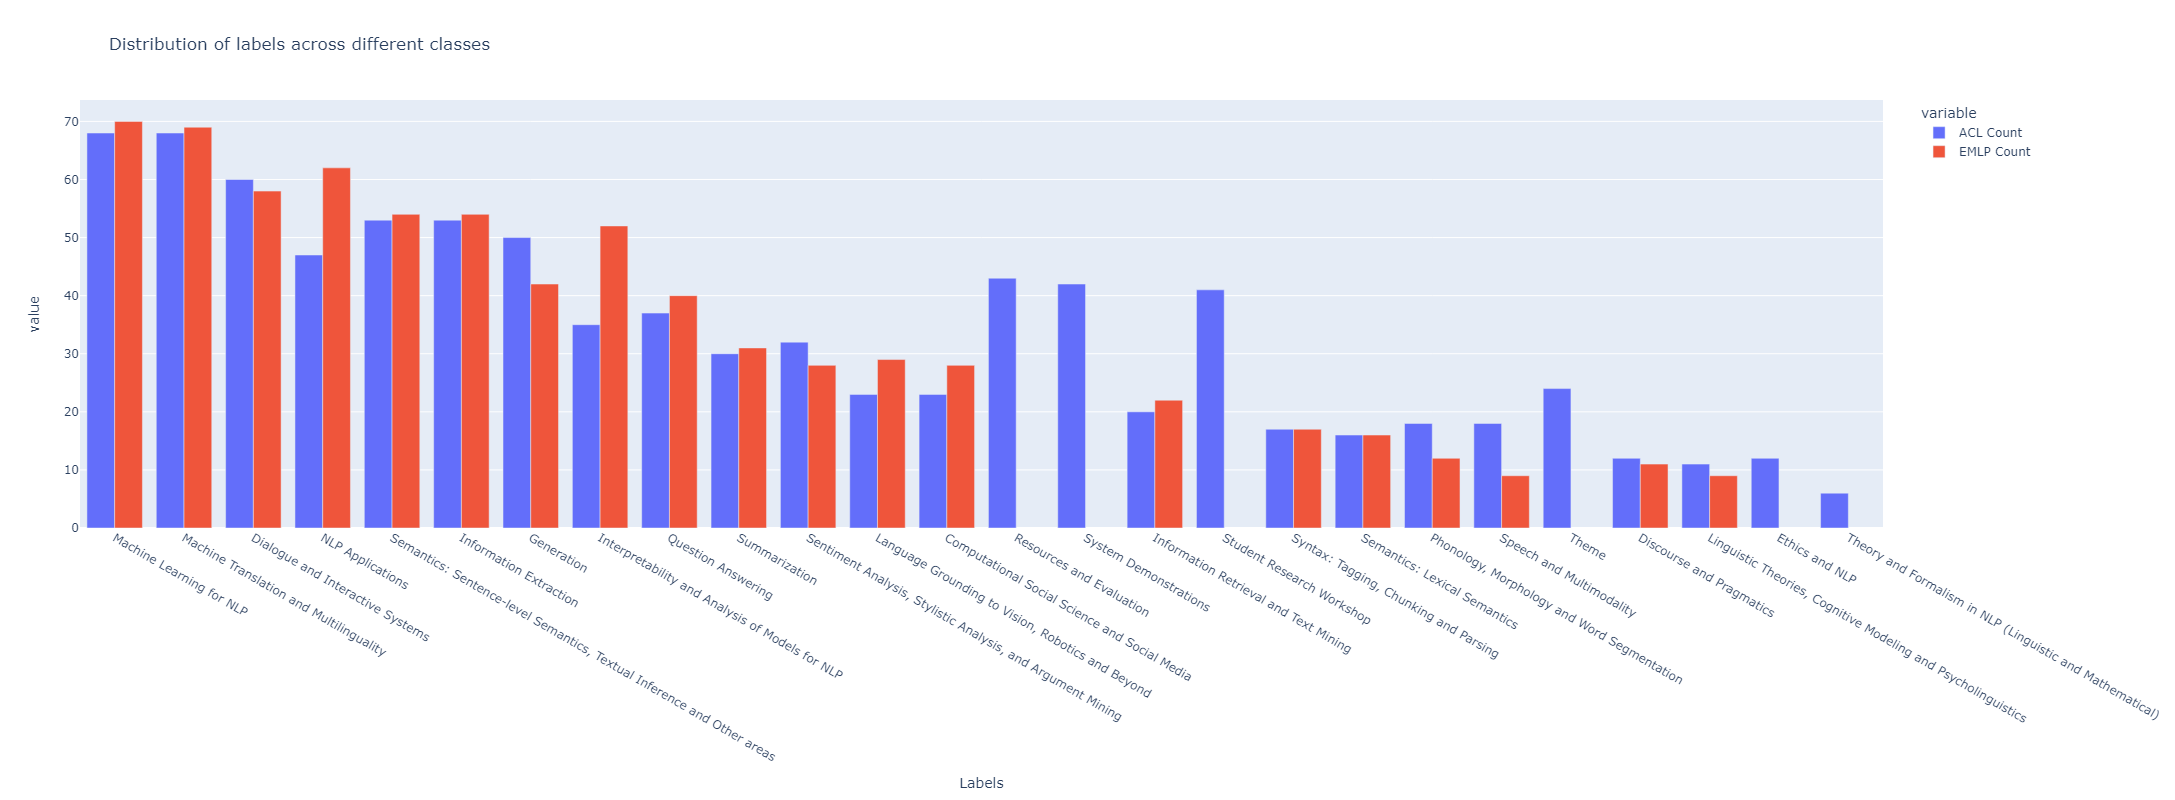

In [30]:
fig = px.bar(df_count, x="Labels", y=["ACL Count", "EMLP Count"], title="Distribution of labels across different classes", barmode='group',
             width=1600, height=800).update_xaxes(categoryorder = "total descending")
fig.show()

### Looking at pretraining a zero shot classifer on ACL dataset (bart-large-mnli)

In [31]:
MODEL_NAME = "facebook/bart-large-mnli"
tokenizer = BartTokenizer.from_pretrained(MODEL_NAME)
N_EPOCHS = 5
BATCH_SIZE = 16
MAX_TOKEN_COUNT = 1024

train_df = df_ACL_entail
val_df = df_EMNLP_entail

In [32]:
class NLPDataset(Dataset):
    
    def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, max_token_len: int = MAX_TOKEN_COUNT):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
    
        data_row = self.data.iloc[index]
        text_premise = data_row["premise"]
        text_hypothesis = data_row["hypothesis"]
        labels = data_row["label"]

        encoding = self.tokenizer.encode_plus(
          text = text_premise,
          text_pair = text_hypothesis,
          add_special_tokens=True,
          max_length=self.max_token_len,
          return_token_type_ids=False,
          padding="max_length",
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return dict(
          text_premise=text_premise,
          text_hypothesis = text_hypothesis,
          input_ids=encoding["input_ids"].flatten(),
          attention_mask=encoding["attention_mask"].flatten(),
          labels=labels
        )

In [33]:
class NLPDataModule(pl.LightningDataModule):
    
    def __init__(self, train_df, val_df, tokenizer, batch_size=BATCH_SIZE, max_token_len=MAX_TOKEN_COUNT):
    
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
    
    def setup(self, stage=None):
        self.train_dataset = NLPDataset(
          self.train_df,
          self.tokenizer,
          self.max_token_len
        )
        self.val_dataset = NLPDataset(
          self.val_df,
          self.tokenizer,
          self.max_token_len
        )
    
    def train_dataloader(self):
        return DataLoader(
          self.train_dataset,
          batch_size=self.batch_size,
          shuffle=True
        )
    
    def val_dataloader(self):
        return DataLoader(
          self.val_dataset,
          batch_size=self.batch_size
        )

In [34]:
data_module = NLPDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [35]:
class NLPClassModel(pl.LightningModule):
    
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
        super().__init__()
        self.bartmnli = BartForSequenceClassification.from_pretrained(MODEL_NAME, return_dict=True, num_labels = n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.CrossEntropyLoss()
    
        for param in self.bartmnli.model.parameters():
            param.requires_grad = False
    
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bartmnli(input_ids, attention_mask=attention_mask).logits
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    
    
    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
    
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        metric = MulticlassAUROC(num_classes=3, average="macro", thresholds=None)
        class_roc_auc = metric(predictions, labels)

        self.logger.experiment.add_scalar(f"roc_auc/Train", class_roc_auc, self.current_epoch)
        
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=self.n_warmup_steps,
          num_training_steps=self.n_training_steps
        )
        
        return dict(
          optimizer = optimizer,
          lr_scheduler = dict(
            scheduler = scheduler,
            interval = 'step'
          )
        )

In [36]:
checkpoint_callback = ModelCheckpoint(
    dirpath = "checkpoints",
    filename = "best-checkpoint",
    save_top_k = 1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
)

logger = TensorBoardLogger("lightning_logs", name="nlpBART")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(
    logger = logger,
    callbacks = [checkpoint_callback, early_stopping_callback],
    max_epochs = N_EPOCHS,
    accelerator = "auto"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(161, 805)

In [38]:
model = NLPClassModel(
  n_classes = 3,
  n_warmup_steps = warmup_steps,
  n_training_steps = total_training_steps
)

In [39]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                          | Params
------------------------------------------------------------
0 | bartmnli  | BartForSequenceClassification | 407 M 
1 | criterion | CrossEntropyLoss              | 0     
------------------------------------------------------------
1.1 M     Trainable params
406 M     Non-trainable params
407 M     Total params
1,629.377 Total estimated model params size (MB)


Epoch 0:  78%|█████████████████████████       | 162/207 [03:10<00:52,  1.18s/it, loss=0.61, v_num=20, train_loss=0.839]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████| 207/207 [04:02<00:00,  1.17s/it, loss=0.61, v_num=20, train_loss=0.839, val_loss=0.731]

Epoch 0, global step 162: 'val_loss' reached 0.73085 (best 0.73085), saving model to 'C:\\Users\\Benjamin Aw\\Desktop\\Extract Scientific Papers\\checkpoints\\best-checkpoint-v19.ckpt' as top 1


Epoch 1:  78%|███████████▋   | 162/207 [03:10<00:53,  1.18s/it, loss=0.484, v_num=20, train_loss=0.459, val_loss=0.731]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|███████████████| 207/207 [04:03<00:00,  1.17s/it, loss=0.484, v_num=20, train_loss=0.459, val_loss=0.879]

Epoch 1, global step 324: 'val_loss' was not in top 1


Epoch 2:  78%|███████████▋   | 162/207 [03:10<00:52,  1.18s/it, loss=0.477, v_num=20, train_loss=0.177, val_loss=0.879]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████| 207/207 [04:02<00:00,  1.17s/it, loss=0.477, v_num=20, train_loss=0.177, val_loss=0.873]

Epoch 2, global step 486: 'val_loss' was not in top 1


Epoch 2: 100%|███████████████| 207/207 [04:02<00:00,  1.17s/it, loss=0.477, v_num=20, train_loss=0.177, val_loss=0.873]


In [40]:
trained_model = NLPClassModel.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes = 3
)

trained_model.eval()
trained_model.freeze()

In [41]:
val_df

premise  \
0    Existing approaches for named entity recogniti...   
1    We analyze social media for detecting the suic...   
2    In this paper, we suggest a minimallysupervise...   
3    Emotions and their evolution play a central ro...   
4    The growth of social media has encouraged the ...   
..                                                 ...   
708  Conditional random fields (CRF) for label deco...   
709  The linear-chain Conditional Random Field (CRF...   
710  Aspect Sentiment Triplet Extraction (ASTE) is ...   
711  Morphologically rich languages seem to benefit...   
712  The connection between dependency trees and sp...   

                                            hypothesis  label  
0    This paper is about Computational Social Scien...      0  
1    This paper is about Computational Social Scien...      0  
2    This paper is about Computational Social Scien...      0  
3    This paper is about Computational Social Scien...      0  
4    This paper is about Computational Social Scien...      0  
..                                                 ...    ...  
708  This paper is about Syntax: Tagging, Chunking ...      0  
709  This paper is about Syntax: Tagging, Chunking ...      0  
710  This paper is about Syntax: Tagging, Chunking ...      0  
711  This paper is about Syntax: Tagging, Chunking ...      0  
712  This paper is about Syntax: Tagging, Chunking ...      0  

[713 rows x 3 columns]

In [42]:
#Creating a validation set that test across all possible hypothesis

val_df.columns = ['premise', 'original hypothesis', 'label']
temp_df = pd.DataFrame({'hypothesis': possible_hypothesis})

val_df = pd.merge(val_df, temp_df, how='cross')

In [43]:
val_df['label'] = val_df['original hypothesis'] == val_df['hypothesis']
val_df['label'] = val_df['label'].replace({True: 0, False: 1})

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

test_dataset = NLPDataset(
    val_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(test_dataset):
    
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    
    predictions.append(prediction.flatten())
    labels.append(item["labels"])

predictions = torch.stack(predictions).detach().cpu()
labels = torch.IntTensor(labels).detach().cpu()

100%|████████████████████████████████████████████████████████████████████████████| 18538/18538 [25:49<00:00, 11.96it/s]


In [45]:
predictions

tensor([[ 1.5253,  1.9891, -4.4387],
        [ 1.6452,  0.8753, -3.4409],
        [ 0.9822,  1.9746, -3.9576],
        ...,
        [ 1.5984,  1.7145, -3.8119],
        [ 1.4111,  1.5194, -3.8988],
        [ 1.1786,  2.1220, -4.1297]])

In [46]:
val_df["Score"] = predictions[:, 0]

In [47]:
val_df

premise  \
0      Existing approaches for named entity recogniti...   
1      Existing approaches for named entity recogniti...   
2      Existing approaches for named entity recogniti...   
3      Existing approaches for named entity recogniti...   
4      Existing approaches for named entity recogniti...   
...                                                  ...   
18533  The connection between dependency trees and sp...   
18534  The connection between dependency trees and sp...   
18535  The connection between dependency trees and sp...   
18536  The connection between dependency trees and sp...   
18537  The connection between dependency trees and sp...   

                                     original hypothesis  label  \
0      This paper is about Computational Social Scien...      1   
1      This paper is about Computational Social Scien...      0   
2      This paper is about Computational Social Scien...      1   
3      This paper is about Computational Social Scien...      1   
4      This paper is about Computational Social Scien...      1   
...                                                  ...    ...   
18533  This paper is about Syntax: Tagging, Chunking ...      0   
18534  This paper is about Syntax: Tagging, Chunking ...      1   
18535  This paper is about Syntax: Tagging, Chunking ...      1   
18536  This paper is about Syntax: Tagging, Chunking ...      1   
18537  This paper is about Syntax: Tagging, Chunking ...      1   

                                              hypothesis     Score  
0      This paper is about Linguistic Theories, Cogni...  1.525278  
1      This paper is about Computational Social Scien...  1.645212  
2      This paper is about Dialogue and Interactive S...  0.982160  
3           This paper is about Discourse and Pragmatics  1.219744  
4                     This paper is about Ethics and NLP  1.477626  
...                                                  ...       ...  
18533  This paper is about Syntax: Tagging, Chunking ...  1.219507  
18534                          This paper is about Theme  0.169746  
18535  This paper is about Theory and Formalism in NL...  1.598442  
18536          This paper is about System Demonstrations  1.411147  
18537      This paper is about Student Research Workshop  1.178621  

[18538 rows x 5 columns]

In [48]:
scored_val_df = val_df.sort_values('Score').drop_duplicates(['premise', 'original hypothesis'], keep='last')

In [49]:
scored_val_df = scored_val_df[['premise', 'hypothesis']]

In [50]:
scored_val_df.columns = ['abstract', 'Max Label']

In [51]:
df_EMNLP_2020 = df_EMNLP_2020.merge(scored_val_df, how="left", on=["abstract"])

In [52]:
df_EMNLP_2020['hypothesis'] = df_EMNLP_2020['hypothesis'].str.replace('This paper is about ', '', regex=False)
df_EMNLP_2020['Max Label'] = df_EMNLP_2020['Max Label'].str.replace('This paper is about ', '', regex=False)

### Prediction for EMNLP 2020 dataset

In [53]:
idx_labels = list(df_EMNLP_2020["Labels"].unique())

cm = confusion_matrix(df_EMNLP_2020['Labels'], df_EMNLP_2020['Max Label'], labels = idx_labels)
cm_df = pd.DataFrame(cm,
                     index = idx_labels, 
                     columns = idx_labels)

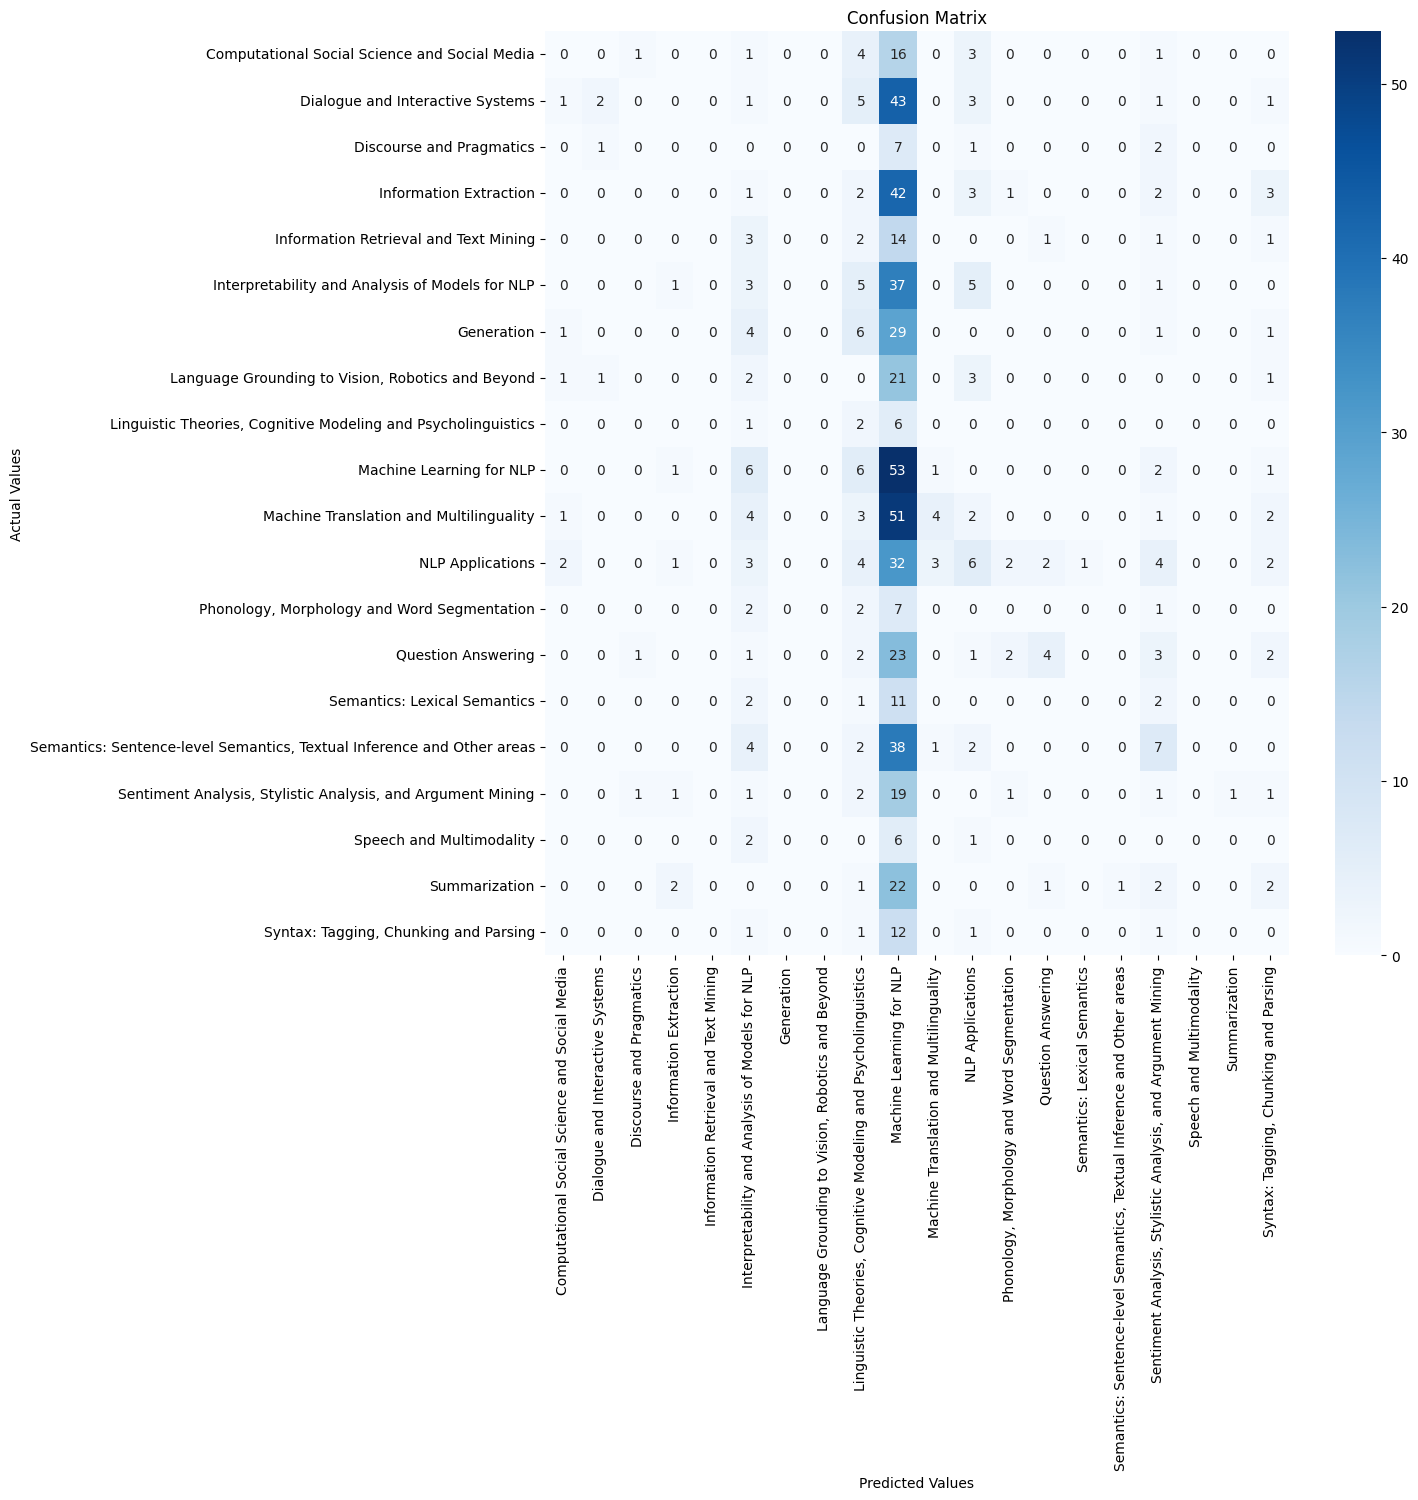

In [54]:
#Plotting the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### Looking the the distribution of the classes

In [55]:
df_ACL_entail['hypothesis'] = df_ACL_entail['hypothesis'].str.replace("This paper is about ", "")

In [56]:
df_ACL_labels_count = df_ACL_entail.groupby(['hypothesis'])['hypothesis'].count()

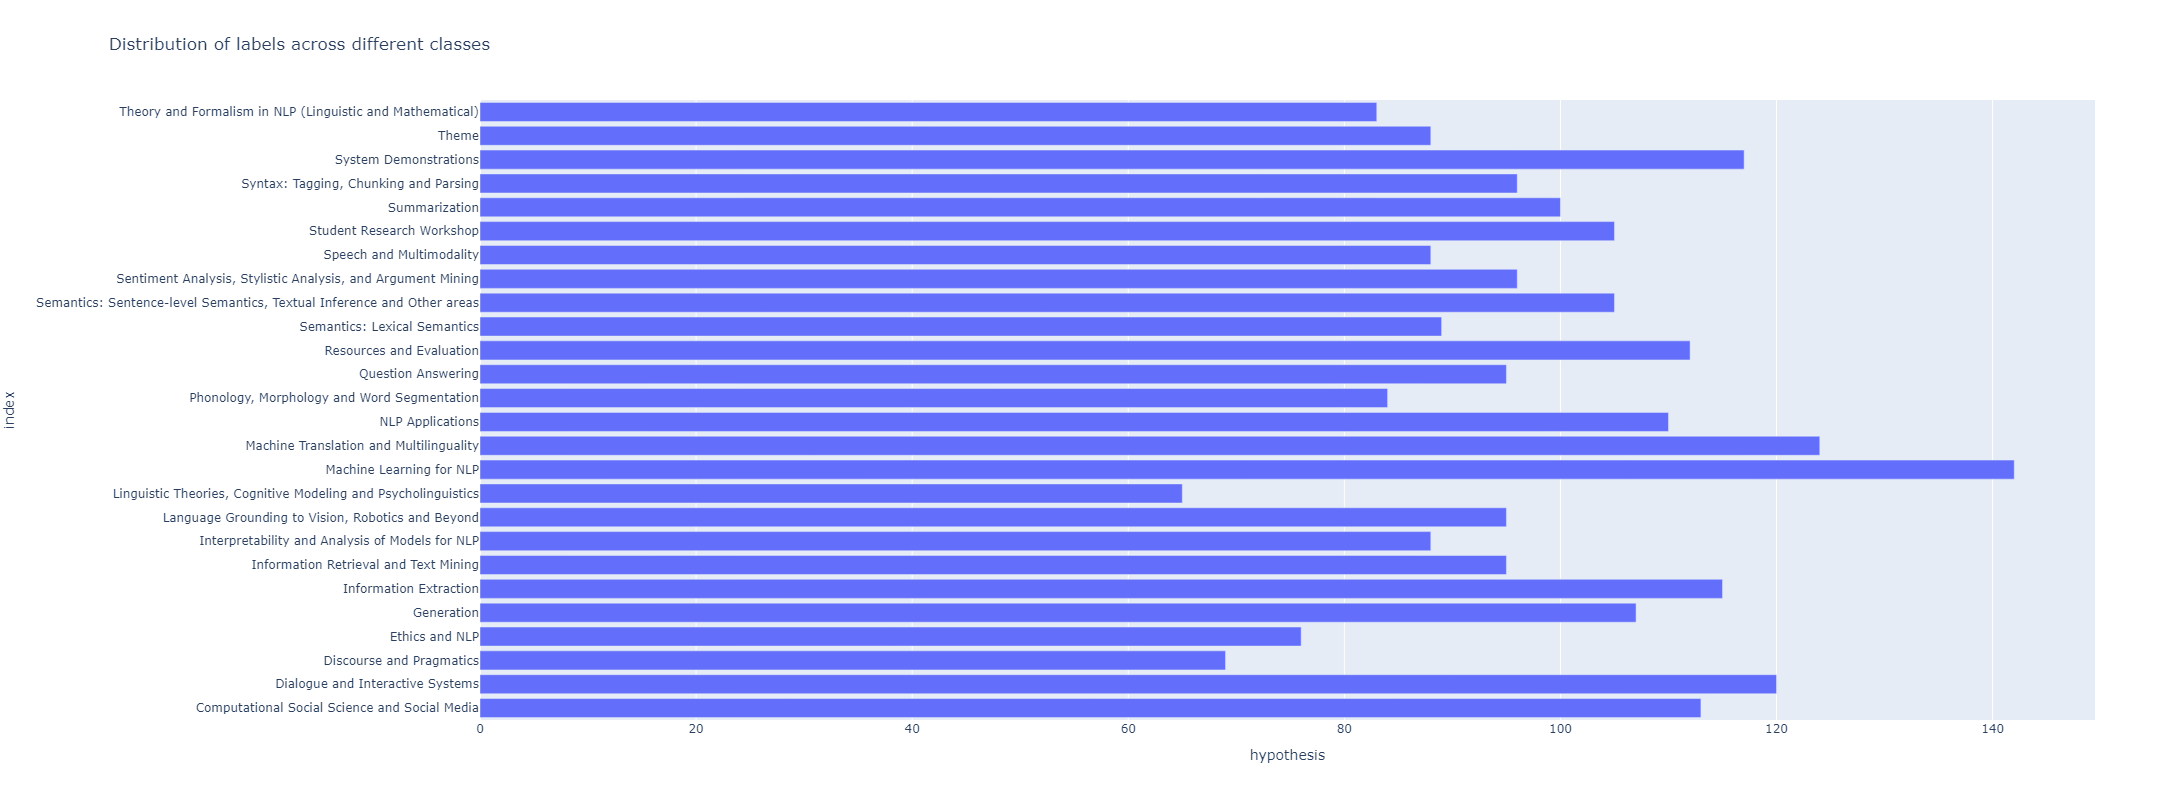

In [57]:
fig = px.bar(df_ACL_labels_count, x="hypothesis",title="Distribution of labels across different classes",
             width=1600, height=800).update_xaxes(categoryorder = "total descending")
fig.show()

### Classifcation results

In [58]:
print(classification_report(df_EMNLP_2020['Labels'], df_EMNLP_2020['Max Label']))

                                                                        precision    recall  f1-score   support

                         Computational Social Science and Social Media       0.00      0.00      0.00        28
                                      Dialogue and Interactive Systems       0.50      0.03      0.06        58
                                              Discourse and Pragmatics       0.00      0.00      0.00        11
                                                        Ethics and NLP       0.00      0.00      0.00         0
                                                            Generation       0.00      0.00      0.00        42
                                                Information Extraction       0.00      0.00      0.00        54
                                 Information Retrieval and Text Mining       0.00      0.00      0.00        22
                       Interpretability and Analysis of Models for NLP       0.07      0.06      0.06  

In [59]:
df_EMNLP_2020["Label outcome"] = df_EMNLP_2020.apply(lambda x: x["Labels"] == x["Max Label"], axis = 1)

In [60]:
df_EMNLP_2020_outcome = df_EMNLP_2020[['Labels', 'Label outcome']].groupby(['Labels', 'Label outcome']).size().reset_index(name='Counts')

In [61]:
df_EMNLP_2020_outcome = df_EMNLP_2020_outcome.sort_values(by = ['Labels','Label outcome'], ascending = [True, False])

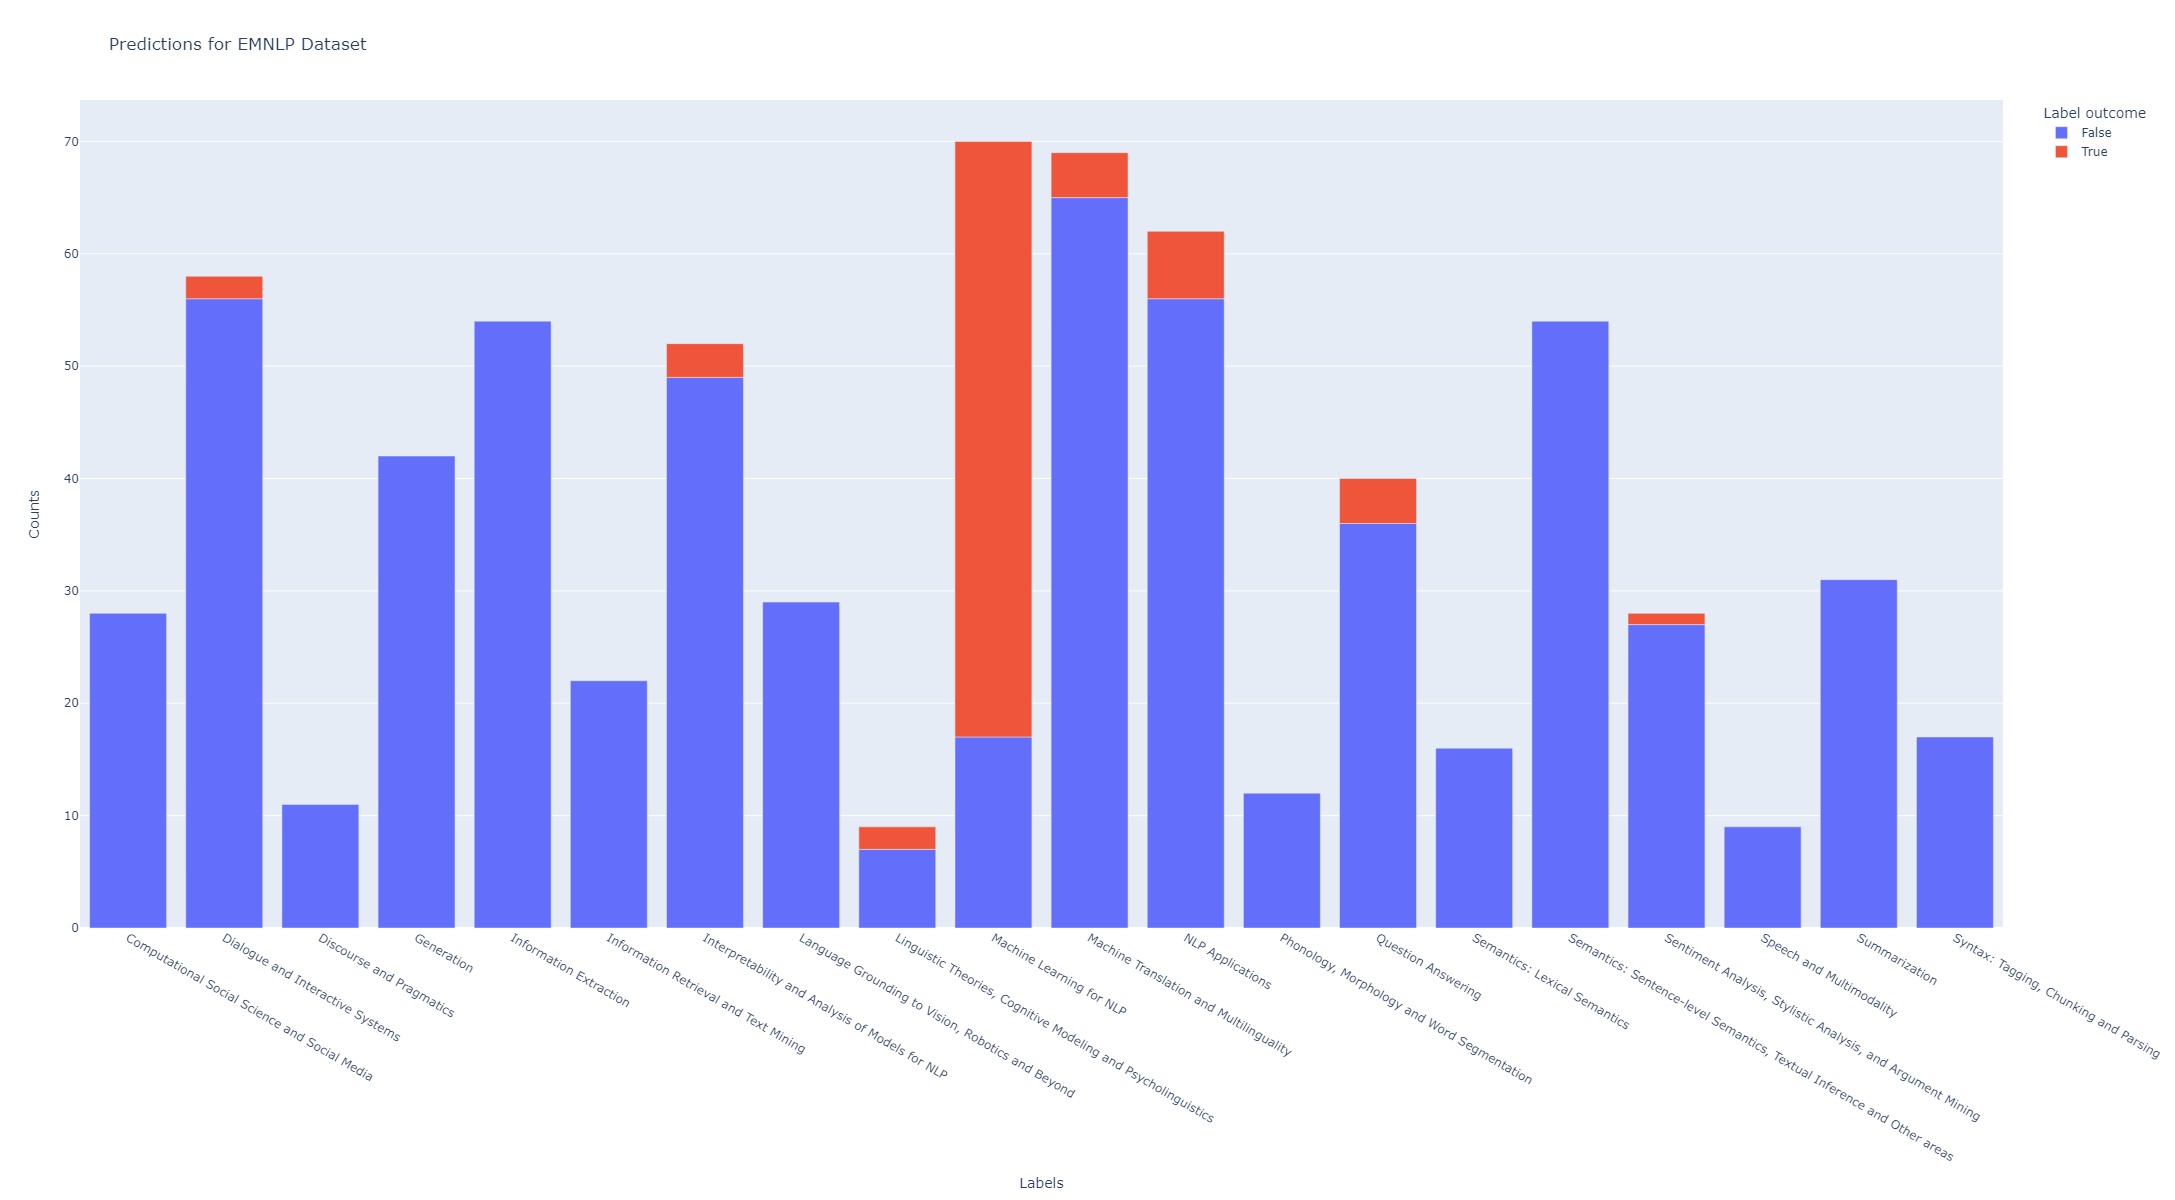

In [62]:
import plotly.express as px

fig = px.bar(df_EMNLP_2020_outcome, x="Labels", y="Counts", color="Label outcome", title="Predictions for EMNLP Dataset",
             width=1800, height=1200)
fig.show()

### Accuracy breakdown by Labels

#### EMNLP 2020

In [63]:
df_EMNLP_2020_accuracy = df_EMNLP_2020_outcome.pivot(index="Labels", columns="Label outcome", values="Counts").reset_index().fillna(0)

In [64]:
df_EMNLP_2020_accuracy["Accuracy"] = df_EMNLP_2020_accuracy[True] / (df_EMNLP_2020_accuracy[False] + df_EMNLP_2020_accuracy[True]) * 100

In [65]:
df_EMNLP_2020_accuracy = df_EMNLP_2020_accuracy.sort_values(by = 'Accuracy', axis=0, ascending=False)
df_EMNLP_2020_accuracy

Label outcome                                             Labels  False  True  \
9                                       Machine Learning for NLP   17.0  53.0   
8              Linguistic Theories, Cognitive Modeling and Ps...    7.0   2.0   
13                                            Question Answering   36.0   4.0   
11                                              NLP Applications   56.0   6.0   
10                       Machine Translation and Multilinguality   65.0   4.0   
6                Interpretability and Analysis of Models for NLP   49.0   3.0   
16             Sentiment Analysis, Stylistic Analysis, and Ar...   27.0   1.0   
1                               Dialogue and Interactive Systems   56.0   2.0   
18                                                 Summarization   31.0   0.0   
17                                      Speech and Multimodality    9.0   0.0   
15             Semantics: Sentence-level Semantics, Textual I...   54.0   0.0   
14                                  Semantics: Lexical Semantics   16.0   0.0   
0                  Computational Social Science and Social Media   28.0   0.0   
12                   Phonology, Morphology and Word Segmentation   12.0   0.0   
7              Language Grounding to Vision, Robotics and Beyond   29.0   0.0   
5                          Information Retrieval and Text Mining   22.0   0.0   
4                                         Information Extraction   54.0   0.0   
3                                                     Generation   42.0   0.0   
2                                       Discourse and Pragmatics   11.0   0.0   
19                         Syntax: Tagging, Chunking and Parsing   17.0   0.0   

Label outcome   Accuracy  
9              75.714286  
8              22.222222  
13             10.000000  
11              9.677419  
10              5.797101  
6               5.769231  
16              3.571429  
1               3.448276  
18              0.000000  
17              0.000000  
15              0.000000  
14              0.000000  
0               0.000000  
12              0.000000  
7               0.000000  
5               0.000000  
4               0.000000  
3               0.000000  
2               0.000000  
19              0.000000